In [1]:
import pandas as pd
import gzip
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import random
import numpy as np

In [2]:
# LOCAL = 'Avenches'
LOCAL = 'New York'
activity_types = ['work', 'education', 'leisure', 'shop']

In [3]:
def round_to_horizon(t):
    """ Help to round a time to 5m intervals """
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), t)
    
    # Find the number of seconds since midnight
    seconds_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).seconds

    # Round to the closest 5 minutes (300 seconds)
    rounded_seconds = round(seconds_since_midnight / 300) * 300
    rounded_dt = dt.replace(hour=0, minute=0, second=0) + timedelta(seconds=rounded_seconds)

    return rounded_dt.time()

def time_to_horizon_interval(t):
    """ Return time horizon corresponding to a timestamp """
    rounded_time = round_to_horizon(t)
    
    # Convert datetime.time to datetime.datetime for calculations
    dt = datetime.combine(datetime.today(), rounded_time)
    
    # Get total minutes since midnight
    minutes_since_midnight = (dt - dt.replace(hour=0, minute=0, second=0)).seconds // 60

    # Convert total minutes to horizon intervals (5 minute intervals)
    horizon_interval = minutes_since_midnight // 5

    return horizon_interval

def convert_to_time(value):
    """ Check that all time values are correct (hours<24)"""
    try:
        # Try converting the value to datetime and extract the time
        return pd.to_datetime(value).time()
    except:
        # Return a placeholder for out-of-range values
        return 1

In [5]:
activity_file_path = '/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_activities.csv.gz'
population_file_path = '/Users/cloe/Documents/GitHub/data_abm/Data/1_Original/nyc_population.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

activity_vaud = read_gzipped_csv(activity_file_path)
population_vaud = read_gzipped_csv(population_file_path)[['id', 'age', 'home_x', 'home_y', 'employed', 'higher_education','gender']]
# population_vaud.rename(columns={'person_id': 'id'}, inplace=True)
# activity_vaud.rename(columns={'person_id': 'id','act_type':'type'}, inplace=True)

In [6]:
#population_local = population_vaud[population_vaud['local'] == LOCAL] 
#population_local_ids = population_local['id'].unique()

population_local=population_vaud
population_local_id= population_vaud['id'].unique()
print(len(population_local_id))
activity_local = activity_vaud[activity_vaud['id'].isin(population_local_id)]
activity_local_filt = activity_local[~activity_local['type'].isin(['other', 'pt interaction', 'home'])] 

329098


## Work facilities distribution

#### If we have to rely on the coordinates

In [7]:
# Filtering for 'work' activities
work_facilities = activity_local[activity_local['type'] == 'Work']

# Creating a new column 'coord_id' which concatenates 'x' and 'y' to form a unique identifier for each facility
work_facilities['coord_id'] = work_facilities['x'].astype(str) + ',' + work_facilities['y'].astype(str)

# Displaying the number of unique work facilities based on coordinates
print(f"There are {work_facilities['coord_id'].nunique()} work facilities in {LOCAL}")

# Counting the number of workers at each facility
work_facilities_count = work_facilities.groupby('coord_id')['id'].count().sort_values(ascending=True)
print(work_facilities_count)

# Displaying the head of the modified DataFrame
work_facilities.head()

# Example to sample one facility based on a specific coordinate
# Assuming 'x' = 123 and 'y' = 456 for a specific facility example
print(work_facilities[work_facilities['coord_id'] == '986413.936352458,190779.81860633'].sample(1))  # Modify '123,456' as needed


There are 93983 work facilities in New York
coord_id
1000000.23148591,222304.237637758      1
986362.198467585,170232.075558053      1
986361.970727626,214577.14677895       1
986361.483820993,203976.22954467       1
986361.169316252,210784.47870618       1
                                    ... 
986866.371376591,212779.246212017     11
980353.014162099,195528.342446068     11
980677.61709285,196892.708341788      12
980537.931338926,195398.612038246     13
915460.384699973,130618.811434739    256
Name: id, Length: 93983, dtype: int64
             id  Unnamed: 1     id.1  type              x              y  \
992184  5791698      992184  5791698  Work  986413.936352  190779.818606   

       start_time  end_time  facility                          coord_id  
992184   13:25:00  14:15:00    496571  986413.936352458,190779.81860633  


/var/folders/1_/2k1w1vfj6pg6ctyrym7wc2tc0000gp/T/ipykernel_32590/1876569594.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  work_facilities['coord_id'] = work_facilities['x'].astype(str) + ',' + work_facilities['y'].astype(str)


#### If we have the unique identifier of the facility

In [8]:
# work_facilities = activity_local[activity_local['type'] == 'work'] 
# print(f"There is {work_facilities['facility'].nunique()} work facilities in {LOCAL}")
# work_facilities_count = work_facilities.groupby('facility')['id'].count().sort_values(ascending=True)
# print(work_facilities_count)
# work_facilities.head()
# print(work_facilities[work_facilities['facility'] == '211602'].sample(1)) # CHUV
# # print(work_facilities[work_facilities['facility'] == '97970'].sample(1)) # CEP training center?

In [9]:
work_facilities_count

coord_id
1000000.23148591,222304.237637758      1
986362.198467585,170232.075558053      1
986361.970727626,214577.14677895       1
986361.483820993,203976.22954467       1
986361.169316252,210784.47870618       1
                                    ... 
986866.371376591,212779.246212017     11
980353.014162099,195528.342446068     11
980677.61709285,196892.708341788      12
980537.931338926,195398.612038246     13
915460.384699973,130618.811434739    256
Name: id, Length: 93983, dtype: int64

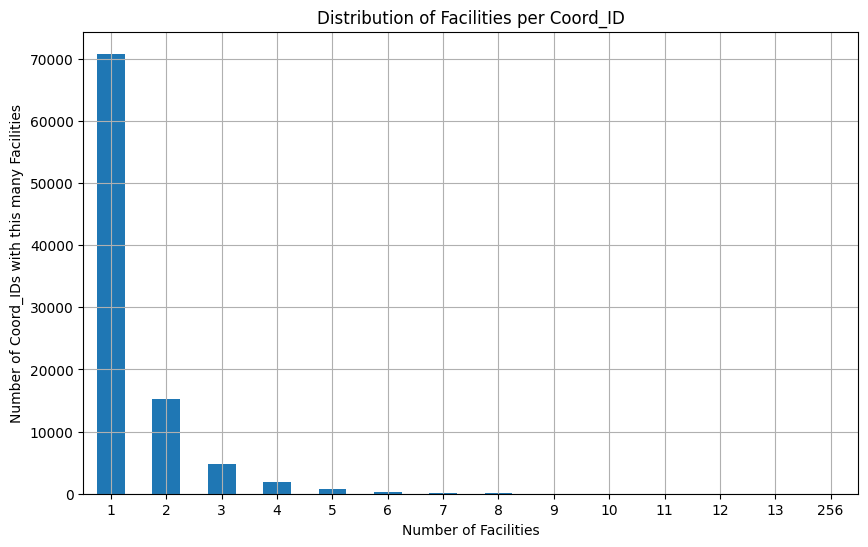

In [10]:
# Count how many 'coord_id' have each specific number of facilities
facility_histogram = work_facilities_count.value_counts().sort_index()

# Creating the histogram
plt.figure(figsize=(10, 6))
facility_histogram.plot(kind='bar')
plt.title('Distribution of Facilities per Coord_ID')
plt.xlabel('Number of Facilities')
plt.ylabel('Number of Coord_IDs with this many Facilities')
plt.xticks(rotation=0)  # Keeps the x labels vertical
plt.grid(True)
plt.show()

In [35]:
# # Créer le diagramme à barres
# plt.figure(figsize=(15, 30))  # Vous devrez peut-être ajuster la taille pour la lisibilité
# plt.barh(work_facilities_count.index.astype(str), work_facilities_count.values, color='skyblue')
# plt.xlabel('Number of Workers')
# plt.ylabel('Facility ID')
# plt.title(f'Number of Workers in Each Work Facility in {LOCAL}')
# plt.grid(axis='x')

# # Afficher le graphique
# plt.show()

In [11]:
# Supposons que work_facilities_count est votre DataFrame avec 'facility' comme index et un comptage des travailleurs comme valeurs
facilities = work_facilities_count.index.tolist()
workers = work_facilities_count.tolist()

# Choisir un établissement aléatoirement, avec le nombre de travailleurs comme poids
chosen_facility = random.choices(facilities, weights=workers, k=1)[0]

# Trouver le nombre de travailleurs dans l'établissement choisi
num_workers_in_chosen_facility = work_facilities_count.loc[chosen_facility]

print(f"Établissement choisi : {chosen_facility}")
print(f"Nombre de travailleurs dans l'établissement choisi : {num_workers_in_chosen_facility}")

Établissement choisi : 992511.996055104,215895.189955106
Nombre de travailleurs dans l'établissement choisi : 3


In [12]:
activity_local_filt

,id,Unnamed: 1,id.1,type,x,y,start_time,end_time,facility
0,0,0,0,Home,979229.529090,196871.104713,00:00:00,10:26:00,0
1,0,1,0,Secondary,984208.138769,199047.458863,10:44:00,11:03:00,1
2,0,2,0,Work,986767.068532,213857.295078,11:25:00,16:10:00,2
3,0,3,0,Secondary,987128.406292,213396.819120,16:13:00,16:20:00,3
4,0,4,0,Secondary,985037.372195,214645.592776,16:26:00,16:50:00,4
...,...,...,...,...,...,...,...,...,...
1417616,8254239,1417616,8254239,Secondary,981578.708106,164301.258188,09:10:00,10:25:00,693414
1417617,8254239,1417617,8254239,Secondary,980983.348972,171563.818327,10:40:00,11:35:00,693415
1417618,8254239,1417618,8254239,Secondary,979699.943944,168287.633142,11:55:00,14:45:00,647065
1417619,8254239,1417619,8254239,Secondary,980714.110554,173305.704034,15:05:00,16:10:00,693416


## Start / duration times distribution of each sub-population

In [13]:
pd.set_option('mode.chained_assignment', None)

# Assuming 'start_time' and 'end_time' are in a format recognized by pandas (like 'HH:MM:SS')
activity_local_filt['start_time'] = pd.to_timedelta(activity_local_filt['start_time'].astype(str))
activity_local_filt['end_time'] = pd.to_timedelta(activity_local_filt['end_time'].astype(str))

# Filter out any NaT values or times that are not within the correct range
# For example, checking that 'start_time' and 'end_time' are less than 24 hours
activity_local_filt = activity_local_filt[
    (activity_local_filt['start_time'] < pd.Timedelta('1 days')) &
    (activity_local_filt['end_time'] < pd.Timedelta('1 days'))
]

# Convert 'start_time' and 'end_time' to 'datetime.time' if they are within a single day.
activity_local_filt['start_time'] = activity_local_filt['start_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)
activity_local_filt['end_time'] = activity_local_filt['end_time'].apply(
    lambda x: (datetime.min + x).time() if isinstance(x, pd.Timedelta) and x < pd.Timedelta(days=1) else x
)

activity_local_filt['start_time_interval'] = activity_local_filt['start_time'].apply(time_to_horizon_interval)
activity_local_filt['end_time_interval'] = activity_local_filt['end_time'].apply(time_to_horizon_interval)
activity_local_filt['duration_interval'] = activity_local_filt['end_time_interval'] - activity_local_filt['start_time_interval']

print(len(activity_local_filt))
activity_local_filt.head()
population_local.head()

1413363


,id,age,home_x,home_y,employed,higher_education,gender
0,0,30-34,979229.52909,196871.104713,1.0,17.0,0.0
1,0,30-34,979229.52909,196871.104713,1.0,17.0,0.0
2,0,30-34,979229.52909,196871.104713,1.0,17.0,0.0
3,0,30-34,979229.52909,196871.104713,1.0,17.0,0.0
4,0,30-34,979229.52909,196871.104713,1.0,17.0,0.0


In [11]:
# plot age distribution 

# Get the individuals id of this 8 sub population : 
# divide population in 4 age range
# divide each of this sub-population in 2 (employed = True vs False) 

# for each sub population
    # for each activity
        # count the number of row by start_time_interval (distribution)
        # count the number of row by duration_interval (distribution)

# for each individual
    # identify its subpopulation
    # for each activity
        # pick a start_time_interval in the corresponding distribution calculated before
        # pick a duration_interval in the corresponding distribution calculated before

In [14]:
population_local['age'].unique()

array(['30-34', '25-29', '55-59', '40-44', '67-69', '35-39', '70-74',
       '45-49', '15-17', '22-24', '10-14', '0-4', '5-9', '75-79', '80-84',
       '50-54', '62-64', '18-19', '20', '65-66', '21', '85+', '60-61'],
      dtype=object)

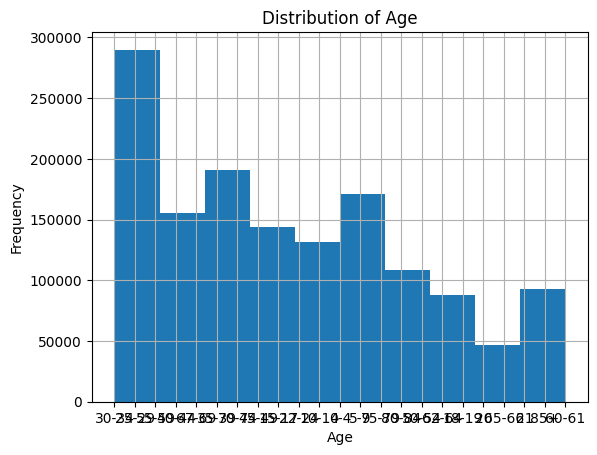

In [15]:
population_local['age'].hist()  # Ajuster le nombre de 'bins' selon le besoin
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

In [16]:
# Define the age ranges as categories directly corresponding to the strings in your DataFrame
age_categories = {
    '0-20': ['0-4', '5-9', '10-14', '15-17', '18-19', '20'],
    '21-40': ['21', '22-24', '25-29', '30-34', '35-39'],
    '41-65': ['40-44', '45-49', '50-54', '55-59', '60-61', '62-64', '65'],
    '66-100': ['66-69', '70-74', '75-79', '80-84', '85+']
}

# Function to map each age category string to a broader category
def map_age_category(age_str):
    for key, age_list in age_categories.items():
        if age_str in age_list:
            return key
    return None  # for NaN or any undefined age group

# Apply this function to create a new column for broad age categories
population_local['age_category'] = population_local['age'].apply(map_age_category)

# Ensure 'employed' column is boolean
population_local['employed'] = population_local['employment'].astype(int).astype(bool)

KeyError: 'employment'

In [ ]:
# Creating sub-populations based on age category and employment status
id_range1 = population_local[population_local['age_category'] == '0-20']
id_range2_emp = population_local[(population_local['age_category'] == '21-40') & (population_local['employed'])]
id_range3_emp = population_local[(population_local['age_category'] == '41-65') & (population_local['employed'])]
id_range4_emp = population_local[(population_local['age_category'] == '66-100') & (population_local['employed'])]
id_range2_unemp = population_local[(population_local['age_category'] == '21-40') & (~population_local['employed'])]
id_range3_unemp = population_local[(population_local['age_category'] == '41-65') & (~population_local['employed'])]
id_range4_unemp = population_local[(population_local['age_category'] == '66-100') & (~population_local['employed'])]


In [ ]:
activity_local_filt['type'].unique()

array(['Secondary', 'Work', 'Home', 'University', 'School'], dtype=object)

In [ ]:
def calculate_distributions(sub_population, activity_local_filt):
    '''Fonction pour calculer la distribution des intervalles de temps de début et de durée
    Returns a dictionary distributions['start_time_interval'] = count // distributions['duration_interval'] = count'''
    distributions = {}
    sub_population_ids = sub_population['id'].unique()
    filtered_activities = activity_local_filt[activity_local_filt['id'].isin(sub_population_ids)]

    for activity_type in filtered_activities['type'].unique():
        activity_data = filtered_activities[filtered_activities['type'] == activity_type]
        start_dist = activity_data['start_time_interval'].value_counts(normalize=True)
        duration_dist = activity_data['duration_interval'].value_counts(normalize=True)
        distributions[activity_type] = {'start': start_dist, 'duration': duration_dist}
    
    return distributions

def get_subpopulation_id(person):
    age_range, employed = person['age'], bool(person['employed'])  # Ensure employed is treated as a boolean
    
    # Define age categories in terms of range strings
    youth_ranges = ['0-4', '5-9', '10-14', '15-17', '18-19', '20']
    young_adult_ranges = ['21', '22-24', '25-29', '30-34', '35-39']
    adult_ranges = ['40-44', '45-49', '50-54', '55-59', '60-61', '62-64', '65']
    senior_ranges = ['66-69', '70-74', '75-79', '80-84', '85+']
    
    # Match the age range and determine the subpopulation ID based on employment
    if age_range in youth_ranges:
        return 'range1'
    elif age_range in young_adult_ranges:
        return 'range2_emp' if employed else 'range2_unemp'
    elif age_range in adult_ranges:
        return 'range3_emp' if employed else 'range3_unemp'
    else:
        return 'range4_emp' if employed else 'range4_unemp'


# Calculer les distributions pour chaque sous-population
distributions = {
    'range1': calculate_distributions(id_range1, activity_local_filt),
    'range2_emp': calculate_distributions(id_range2_emp, activity_local_filt),
    'range3_emp': calculate_distributions(id_range3_emp, activity_local_filt),
    'range4_emp': calculate_distributions(id_range4_emp, activity_local_filt),
    'range2_unemp': calculate_distributions(id_range2_unemp, activity_local_filt),
    'range3_unemp': calculate_distributions(id_range3_unemp, activity_local_filt),
    'range4_unemp': calculate_distributions(id_range4_unemp, activity_local_filt),
}
print(distributions['range4_emp'])

{'Secondary': {'start': start_time_interval
144    0.021776
158    0.021554
180    0.019760
132    0.015343
140    0.014948
         ...   
265    0.000068
241    0.000048
70     0.000039
66     0.000019
238    0.000010
Name: proportion, Length: 196, dtype: float64, 'duration': duration_interval
3      0.088115
2      0.088048
1      0.081172
4      0.072039
6      0.049067
         ...   
64     0.000029
83     0.000029
88     0.000019
155    0.000010
148    0.000010
Name: proportion, Length: 102, dtype: float64}, 'Home': {'start': start_time_interval
110    0.034016
130    0.029372
168    0.026470
142    0.024264
172    0.023742
         ...   
232    0.000116
224    0.000058
106    0.000058
40     0.000058
24     0.000058
Name: proportion, Length: 151, dtype: float64, 'duration': duration_interval
11     0.050212
3      0.046729
8      0.035584
26     0.034829
5      0.033030
         ...   
57     0.000174
74     0.000174
79     0.000116
164    0.000058
108    0.000058
Name: propor

In [ ]:
# Initialisation des colonnes pour les durées et heures de début d'activité
for activity_type in activity_types:
    population_local[f'{activity_type}_start'] = 0
    population_local[f'{activity_type}_dur'] = 0

# Pour chaque individu et activity type, choisir aléatoirement un intervalle de temps de début et de durée
for index, person in population_local.iterrows():
    subpop_id = get_subpopulation_id(person)
    for activity_type, dist in distributions[subpop_id].items():
        chosen_start = np.random.choice(dist['start'].index, p=dist['start'].values)
        chosen_duration = np.random.choice(dist['duration'].index, p=dist['duration'].values)
        if subpop_id == 'range1' and activity_type == 'work':
            chosen_start = 0
            chosen_duration = 0
        population_local.at[index, f'{activity_type}_start'] = chosen_start
        population_local.at[index, f'{activity_type}_dur'] = chosen_duration
    
# population_local.sort_values('age').head(30)
# population_local.head(40)

In [ ]:
population_local.columns

Index(['id', 'age', 'home_x', 'home_y', 'employment', 'higher_education',
       'gender', 'age_category', 'employed', 'work_start', 'work_dur',
       'education_start', 'education_dur', 'leisure_start', 'leisure_dur',
       'shop_start', 'shop_dur', 'Secondary_start', 'Secondary_dur',
       'Work_start', 'Work_dur', 'Home_start', 'Home_dur', 'University_start',
       'University_dur', 'School_start', 'School_dur'],
      dtype='object')

In [ ]:
population_local.sort_values('age').head(30)
population_local.head(40)

,id,age,home_x,home_y,employment,higher_education,gender,age_category,employed,work_start,...,Secondary_start,Secondary_dur,Work_start,Work_dur,Home_start,Home_dur,University_start,University_dur,School_start,School_dur
0,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,228.0,1.0,81.0,20.0,168.0,31.0,126.0,45.0,92.0,81.0
1,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,258.0,30.0,105.0,37.0,200.0,16.0,215.0,57.0,101.0,74.0
2,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,223.0,6.0,108.0,119.0,122.0,18.0,135.0,12.0,104.0,16.0
3,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,235.0,0.0,97.0,129.0,184.0,58.0,159.0,104.0,99.0,71.0
4,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,166.0,1.0,95.0,110.0,156.0,35.0,213.0,34.0,94.0,102.0
5,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,234.0,12.0,93.0,107.0,167.0,12.0,121.0,50.0,91.0,83.0
6,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,212.0,35.0,79.0,119.0,124.0,26.0,168.0,69.0,95.0,102.0
7,0,30-34,979229.529090,196871.104713,0.0,0.0,1.0,21-40,False,0,...,126.0,1.0,110.0,48.0,193.0,8.0,104.0,30.0,95.0,78.0
8,1,25-29,979654.518402,196673.918013,0.0,0.0,1.0,21-40,False,0,...,213.0,1.0,113.0,64.0,104.0,44.0,136.0,57.0,96.0,84.0
9,1,25-29,979654.518402,196673.918013,0.0,0.0,1.0,21-40,False,0,...,262.0,1.0,156.0,39.0,203.0,2.0,108.0,36.0,92.0,77.0


# Distance work / home

### Ours

In [16]:
# population_local_sample = population_vaud[population_vaud['local'] == LOCAL] 
# # Drop rows where any of the required columns have NaNs
# population_local_sample.dropna(subset=['home_x', 'home_y', 'work_x', 'work_y'], inplace=True)

# # Now apply the distance calculation
# population_local_sample['distance_H2W'] = np.sqrt(
#     (population_local_sample['home_x'] - population_local_sample['work_x'])**2 +
#     (population_local_sample['home_y'] - population_local_sample['work_y'])**2
# )
# population_local_sample['distance_H2W'].mean()

In [17]:
# import matplotlib.pyplot as plt
# # Plot the distribution of distance
# plt.figure(figsize=(10, 6))
# plt.hist(population_local_sample['distance_H2W'], bins=30, alpha=0.7, color='blue')
# plt.title('Distribution of Distance from Home to Work')
# plt.xlabel('Distance')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

# # Plot the boxplot of the distance
# plt.figure(figsize=(10, 2))
# plt.boxplot(population_local_sample['distance_H2W'].dropna(), vert=False)  # Drop NA values for boxplot
# plt.title('Boxplot of Distance from Home to Work')
# plt.xlabel('Distance')
# plt.grid(True)
# plt.show()

### Real one

# Travel speed study

In [21]:
DATA_PATH = "/Users/cloe/Documents/GitHub/data abm/Data/1_Original/"
trip_file = DATA_PATH +'vaud_trips.csv.gz'

def read_gzipped_csv(file_path):
    with gzip.open(file_path, 'rt') as file:
        df = pd.read_csv(file)
    return df

trip_df = read_gzipped_csv(trip_file)[['id', 'mode', 'trav_time', 'start_link', 'end_link']]

In [ ]:
# activity_local.head(2)
# ocnvert to datetime, replace NAN, filter all garbage activities?

In [22]:
# Select only required columns from activity_local and rename them for clarity
activity_local_start = activity_local.drop_duplicates(subset=['link']).copy()
activity_local_start = activity_local_start[['link', 'x', 'y']].add_suffix('_start')

activity_local_end = activity_local.drop_duplicates(subset=['link']).copy()
activity_local_end = activity_local_end[['link', 'x', 'y']].add_suffix('_end')


trip_df_local = trip_df[trip_df['id'].isin(population_local_ids)]
trip_df_local = trip_df_local.dropna(subset= ['trav_time'], axis=0)
trip_df_local = trip_df_local.sample(frac=1)
# trip_df_local_filt = trip_df_local[trip_df_local['mode']=='walk']
trip_df_local_filt = trip_df_local
print(len(trip_df_local_filt))

620746


In [23]:
# Merge trip_df with activity_local_start
trip_detailed = trip_df_local_filt.merge(activity_local_start, how='left', left_on='start_link', right_on='link_start')
trip_detailed = trip_detailed.drop(columns=['link_start'])  # Drop the extra link column
trip_detailed = trip_detailed.dropna(subset=['x_start', 'y_start'], axis=0)

# Merge trip_detailed with activity_local_end
trip_detailed2 = trip_detailed.merge(activity_local_end, how='left', left_on='end_link', right_on='link_end')
trip_detailed2 = trip_detailed2.drop(columns=['link_end'])  # Drop the extra link column
trip_detailed2 = trip_detailed2.dropna(subset=['x_end', 'y_end'], axis=0)
trip_detailed2.sample(5)

,id,mode,trav_time,start_link,end_link,x_start,y_start,x_end,y_end
28327,6731246,walk,00:04:51,243296,351233,2541792.0,1154426.0,2.541610e+06,1.154230e+06
272315,6337596,walk,00:00:58,193657,pt_8501181,2537940.0,1152434.0,2.537975e+06,1.152487e+06
136100,6499132,car,00:17:19,536976,662286,2540458.0,1150897.0,2.543928e+06,1.156126e+06
286381,6734381,walk,00:00:00,904710,904710,2539135.0,1155149.0,2.539135e+06,1.155149e+06
154578,7070204,bike,00:00:00,543530,543530,2538094.0,1154411.0,2.538094e+06,1.154411e+06


In [24]:
trip_detailed2['distance'] = np.sqrt(
    (trip_detailed2['x_start'] - trip_detailed2['x_end'])**2 +
    (trip_detailed2['y_start'] - trip_detailed2['y_end'])**2
) / 1000

# Convert trav_time to timedelta if it's not already
trip_detailed2['trav_time'] = pd.to_timedelta(trip_detailed2['trav_time'])


# Print the total number of rows in the DataFrame
print("Total number of rows:", len(trip_detailed2))

# Check for rows with zero or near-zero travel time
# Adjust the condition if necessary (e.g., check for extremely small values if needed)
zero_travel_time = trip_detailed2['trav_time'].dt.total_seconds() <= 10
print("Number of rows with zero or near-zero travel time:", zero_travel_time.sum())

# Set speed to NaN where travel time is zero or near-zero
trip_detailed2.loc[zero_travel_time, 'speed'] = np.nan

# Recalculate speed for non-zero travel times
valid_travel_time = trip_detailed2['trav_time'].dt.total_seconds() > 0
trip_detailed2.loc[valid_travel_time, 'speed'] = trip_detailed2.loc[valid_travel_time, 'distance'] / (trip_detailed2.loc[valid_travel_time, 'trav_time'].dt.total_seconds() / 3600)

# Check the mean speed again
print("Mean speed:", trip_detailed2['speed'].mean())



Total number of rows: 620746
Number of rows with zero or near-zero travel time: 44362
Mean speed: 13.225502565130942


In [53]:
a=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/activities_Lausanne.csv')
p=pd.read_csv('/Users/cloe/Documents/GitHub/data_abm/Data/2_PreProcessed/population_Lausanne.csv')

In [54]:
a.head(5)

,id,type,facility,x,y,group,earliest_start,latest_start,max_duration,min_duration
0,6715836,education,386198,2537240,1153624,1,84,276,120,2
1,7104895,education,386196,2538276,1153687,1,84,276,120,2
2,6947324,education,381489,2538852,1151866,1,84,276,120,2
3,6717525,education,382539,2538698,1152910,1,84,276,120,2
4,6492917,education,383054,2537240,1152746,1,84,276,120,2


In [55]:
p.head(5)

,id,local,age,employed,home_x,home_y,homeid,work_start,work_dur,education_start,education_dur,leisure_start,leisure_dur,shop_start,shop_dur,work_id,work_x,work_y
0,6355522,Lausanne,67,False,2536925,1153244,home2810131,185,3,185,25,144,80,152,15,529782,2537690,1152550
1,6437641,Lausanne,82,False,2539498,1153939,home2892250,184,80,185,12,107,4,182,0,282158,2540922,1152776
2,6727547,Lausanne,66,False,2537331,1153061,home3024903,226,4,213,30,175,2,170,6,498469,2554384,1173127
3,6481832,Lausanne,88,False,2537532,1151163,home2919301,155,26,169,20,234,10,181,6,105125,2538478,1152655
4,6936765,Lausanne,10,False,2537407,1154821,home3076134,0,0,95,32,174,16,140,3,134009,2532026,1152003


In [56]:
population_local.head(5)

,id,age,home_x,home_y,employment,higher_education,gender,age_category,employed,work_start,...,Secondary_start,Secondary_dur,Work_start,Work_dur,Home_start,Home_dur,University_start,University_dur,School_start,School_dur
0,0,30-34,979229.52909,196871.104713,0.0,0.0,1.0,21-40,False,0,...,228.0,1.0,81.0,20.0,168.0,31.0,126.0,45.0,92.0,81.0
1,0,30-34,979229.52909,196871.104713,0.0,0.0,1.0,21-40,False,0,...,258.0,30.0,105.0,37.0,200.0,16.0,215.0,57.0,101.0,74.0
2,0,30-34,979229.52909,196871.104713,0.0,0.0,1.0,21-40,False,0,...,223.0,6.0,108.0,119.0,122.0,18.0,135.0,12.0,104.0,16.0
3,0,30-34,979229.52909,196871.104713,0.0,0.0,1.0,21-40,False,0,...,235.0,0.0,97.0,129.0,184.0,58.0,159.0,104.0,99.0,71.0
4,0,30-34,979229.52909,196871.104713,0.0,0.0,1.0,21-40,False,0,...,166.0,1.0,95.0,110.0,156.0,35.0,213.0,34.0,94.0,102.0


In [57]:
activity_local_filt.head()


,Unnamed: 0,id,type,x,y,start_time,end_time,start_time_interval,end_time_interval,duration_interval
1,1,0,Secondary,984208.138769,199047.458863,10:44:00,11:03:00,129,133,4
2,2,0,Work,986767.068532,213857.295078,11:25:00,16:10:00,137,194,57
3,3,0,Secondary,987128.406292,213396.819120,16:13:00,16:20:00,195,196,1
4,4,0,Secondary,985037.372195,214645.592776,16:26:00,16:50:00,197,202,5
5,5,0,Work,986904.323463,212838.636491,16:57:00,21:43:00,203,261,58
